In [1]:
!pip install torchvision


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


'C:\\Users\\vikto\\python\\python.exe'

In [1]:
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import os
import numpy as np
from skimage import io

class PMnet_usc_per_pixel(Dataset): 
    def __init__(self, csv_file,
                 dir_dataset="data/USC/",               
                 transform= transforms.ToTensor()):
        self.ind_val = pd.read_csv(csv_file)
        self.dir_dataset = dir_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ind_val)
    
    def __getitem__(self, idx):

        #Load city map
        self.dir_buildings = self.dir_dataset+ "/map/"
        img_name_buildings = os.path.join(self.dir_buildings, str((self.ind_val.iloc[idx, 0]))) + ".png"
        image_buildings = np.asarray(io.imread(img_name_buildings))
        
        #Load Tx (transmitter):
        self.dir_Tx = self.dir_dataset+ "/Tx/" 
        img_name_Tx = os.path.join(self.dir_Tx, str((self.ind_val.iloc[idx, 0]))) + ".png"
        image_Tx = np.asarray(io.imread(img_name_Tx))
        
        image_buildings_Tx=np.stack([image_buildings, image_Tx], axis=2)

        
        positions = torch.tensor(self.ind_val.iloc[idx,1:3].values, dtype=torch.float32)
        powers = torch.tensor(self.ind_val.iloc[idx,3], dtype=torch.float32)

        if self.transform:            
            image_buidlings = self.transform(image_buildings_Tx).type(torch.float32)            

        inputs = (positions, image_buildings_Tx)
            
        return [inputs , powers]

In [2]:
csv_file = 'data/USC/samples.csv'
dir_dataset="data/USC/"

per_pixel_dataset = PMnet_usc_per_pixel(csv_file)

x: 12.0, y: 93.0
torch.Size([2, 256, 256, 2])


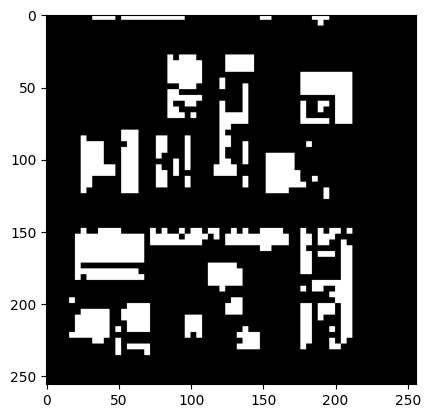

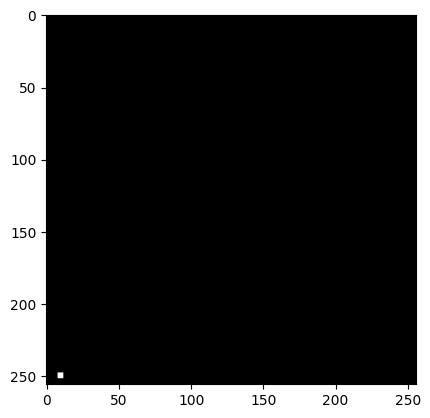

power: 176.0


In [8]:
from torch.utils.data import DataLoader

data_loader = DataLoader(per_pixel_dataset, batch_size=2, shuffle=False)

sample = next(iter(data_loader))

positions, image_buildings_Tx = sample[:][0]
powers = sample[:][1]

print("x: {}, y: {}".format(positions[0,0], positions[0,1]))

import matplotlib.pyplot as plt

print(image_buildings_Tx.shape)

img_buildings = image_buildings_Tx[0][:,:,0]

plt.imshow(img_buildings.squeeze(), cmap='gray')
plt.show()

img_Tx = image_buildings_Tx[0][:,:,1]

plt.imshow(img_Tx.squeeze(), cmap='gray')
plt.show()

print("power: {}".format(powers[0]))

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

# Assuming you have a PyTorch dataset called 'my_dataset'
# Replace this with your actual dataset instantiation

# Set a fixed seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Define the sizes for train, test, and validation sets
total_samples = len(per_pixel_dataset)
train_size = int(0.8 * total_samples)
test_size = int(0.1 * total_samples)
val_size = total_samples - train_size - test_size

# Use random_split to split the dataset
train_dataset, test_dataset, val_dataset = random_split(
    per_pixel_dataset, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(seed)
)

# Print sizes of the split datasets
print("Training set size:", len(train_dataset))
print("Testing set size:", len(test_dataset))
print("Validation set size:", len(val_dataset))


Training set size: 38733823
Testing set size: 4841727
Validation set size: 4841729
